# Basic CFHT cluster data analysis using the LSST stack

## Initialize butler and get references to some deepCoadd catalogs

In [1]:
import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage

butler = dafPersist.Butler("/sps/lsst/dev/lsstprod/clusters/MACSJ2243.3-0935/output/coadd_dir")
dataId_r = {'tract':0, 'filter':'r', 'patch':'1,3'}
dataId_g = {'tract':0, 'filter':'g', 'patch':'1,3'}
dataId_i = {'tract':0, 'filter':'i', 'patch':'1,3'}

meas_r = butler.get('deepCoadd_meas', dataId=dataId_r)
meas_g = butler.get('deepCoadd_meas', dataId=dataId_g)
meas_i = butler.get('deepCoadd_meas', dataId=dataId_i)

md_r = butler.get('deepCoadd_calexp', dataId=dataId_r)
md_g = butler.get('deepCoadd_calexp', dataId=dataId_g)
md_i = butler.get('deepCoadd_calexp', dataId=dataId_i)
calib_r = md_r.getCalib()
calib_g = md_g.getCalib()
calib_i = md_i.getCalib()

schema = meas_r.getSchema()

## print all the keys available in the deepCoad_meas catalog 

In [2]:
print schema.getOrderedNames()

('id', 'coord_ra', 'coord_dec', 'parent', 'flags_negative', 'merge_footprint_i', 'merge_footprint_r', 'merge_footprint_z', 'merge_footprint_g', 'merge_footprint_u', 'merge_footprint_sky', 'merge_peak_i', 'merge_peak_r', 'merge_peak_z', 'merge_peak_g', 'merge_peak_u', 'merge_peak_sky', 'deblend_nChild', 'deblend_deblendedAsPsf', 'deblend_psfCenter_x', 'deblend_psfCenter_y', 'deblend_psfFlux', 'deblend_tooManyPeaks', 'deblend_parentTooBig', 'deblend_masked', 'deblend_skipped', 'deblend_rampedTemplate', 'deblend_patchedTemplate', 'deblend_hasStrayFlux', 'base_GaussianCentroid_x', 'base_GaussianCentroid_y', 'base_GaussianCentroid_flag', 'base_GaussianCentroid_flag_noPeak', 'base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_NaiveCentroid_flag', 'base_NaiveCentroid_flag_noCounts', 'base_NaiveCentroid_flag_edge', 'base_SdssCentroid_x', 'base_SdssCentroid_y', 'base_SdssCentroid_xSigma', 'base_SdssCentroid_ySigma', 'base_SdssCentroid_flag', 'base_SdssCentroid_flag_edge', 'base_SdssCentroid_f

In [3]:
import math
import lsst.afw.geom as afwGeom

# MACSJ2243.3-0935 coordinates 
raClust = afwGeom.degToRad(340.83)
deClust = afwGeom.degToRad(-9.59)

# Get keys from the measurement catalog
# The following is not strictly necessary as one could use the get("key_name") method to access values in the
# catalogs, but it is much more efficient to use get(key)
fluxKey = schema["modelfit_CModel_flux"].asKey()
fluxSigmaKey = schema["modelfit_CModel_fluxSigma"].asKey()
fluxFlagKey = schema["modelfit_CModel_flag"].asKey()
extKey = schema["base_ClassificationExtendedness_value"].asKey()
extFlagKey = schema["base_ClassificationExtendedness_flag"].asKey()

e1Key = schema["ext_shapeHSM_HsmShapeRegauss_e1"].asKey()
e2Key = schema["ext_shapeHSM_HsmShapeRegauss_e2"].asKey()
regaussFlagKey = schema["ext_shapeHSM_HsmShapeRegauss_flag"].asKey()

raKey = schema["coord_ra"].asKey()
decKey = schema["coord_dec"].asKey()

# Initialize some lists
magR = []
magG = []
magI = []
e1R = []
e2R = []
raSrc = []
decSrc = []

# Loop over deblended sources in the r, g, and i deepCoadd_meas catalogs
for i in range(len(meas_r)) :
    # Select galaxies (and reject stars)
    if meas_r[i].get(extFlagKey) or meas_r[i].get(extKey) < 0.5 :
        continue
    # Select sources which have a proper flux value in r, g and i bands
    # Notice that it would not be strictly necessary with forced photometry
    if meas_r[i].get(fluxFlagKey) or meas_g[i].get(fluxFlagKey) or meas_i[i].get(fluxFlagKey) :
        continue
    flux_r = meas_r[i].get(fluxKey)
    flux_g = meas_g[i].get(fluxKey)
    flux_i = meas_i[i].get(fluxKey)
    if flux_r <= 0. or flux_g <= 0. or flux_i <= 0. :
        continue
    fluxS_r = meas_r[i].get(fluxSigmaKey)
    fluxS_g = meas_g[i].get(fluxSigmaKey)
    fluxS_i = meas_i[i].get(fluxSigmaKey)
    if flux_r/fluxS_r < 5. or flux_g/fluxS_g < 5. or flux_i/fluxS_i < 5. :
        continue
    if meas_i[i].get(regaussFlagKey) :
        continue
        
    # Need to use a calibobject in order to convert flux to magnitude
    mag_r = calib_r.getMagnitude(flux_r)
    mag_g = calib_g.getMagnitude(flux_g)
    mag_i = calib_i.getMagnitude(flux_i)
    
    # Try to get ellipticity measurements
    e1_r = meas_i[i].get(e1Key)
    e2_r = meas_i[i].get(e2Key)
    
    magR.append(mag_r)
    magG.append(mag_g)
    magI.append(mag_i)
    
    raSrc.append(float(meas_r[i].get(raKey)))
    decSrc.append(float(meas_r[i].get(decKey)))
    
    e1R.append(e1_r)
    e2R.append(e2_r)
    
print "Nbr. of selected sources %d"%len(magR)

Nbr. of selected sources 4934


## Analysis and plots

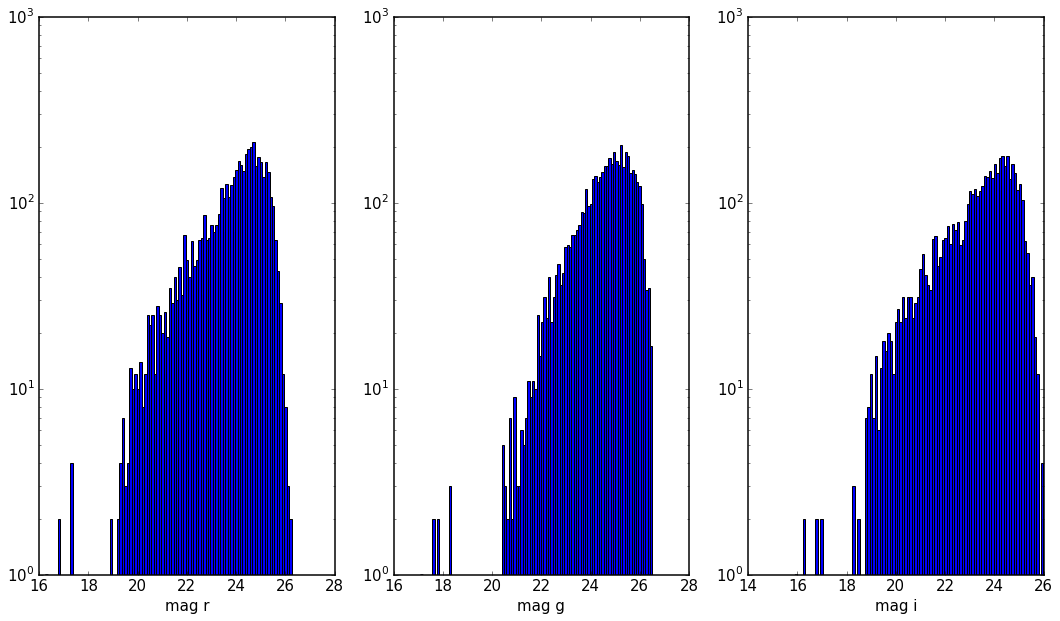

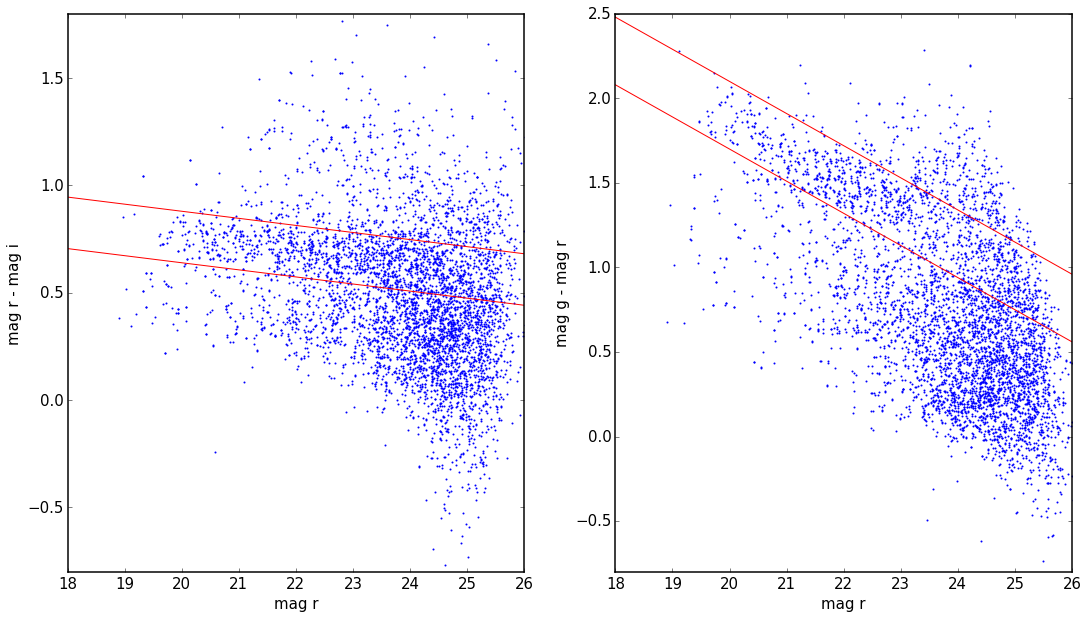

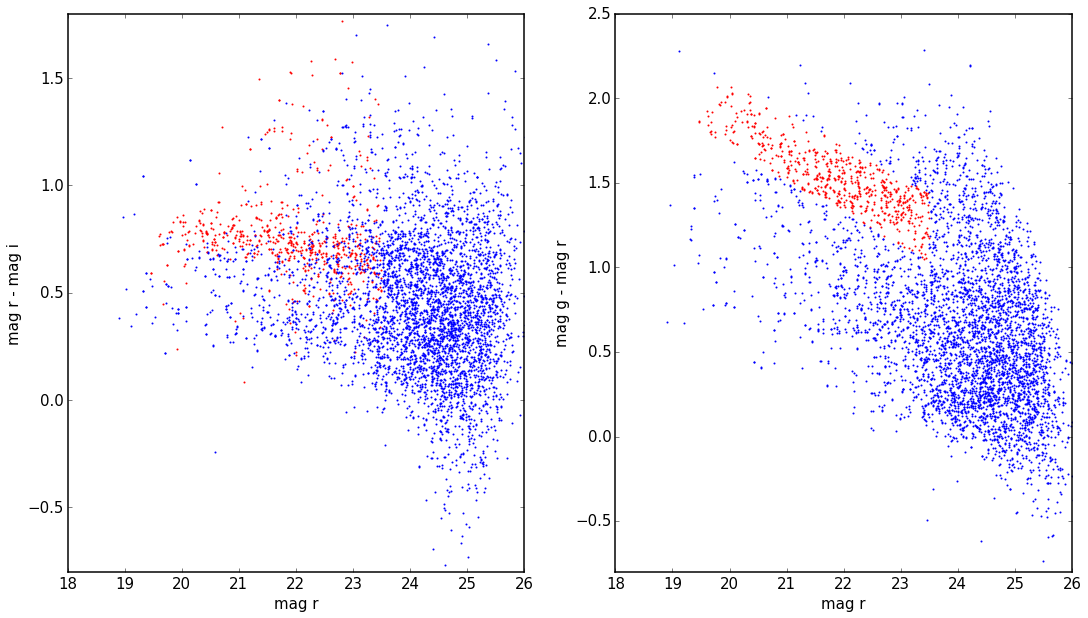

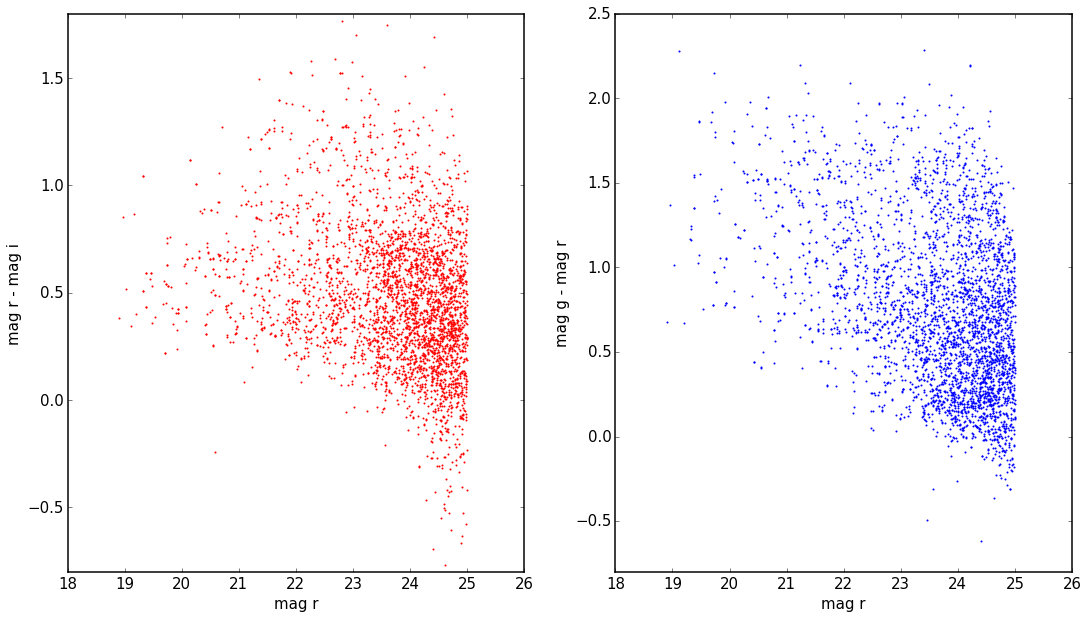

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

# Plot magnitudes
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18, 10))
ax0.hist(magR, bins=100)
ax0.set_yscale('log')
ax0.set_xlabel("mag r", fontsize=15)
ax0.tick_params(labelsize=15)
ax1.hist(magG, bins=100)
ax1.set_yscale('log')
ax1.set_xlabel("mag g", fontsize=15)
ax1.tick_params(labelsize=15)
ax2.hist(magI, bins=100)
ax2.set_yscale('log')
ax2.set_xlabel("mag i", fontsize=15)
ax2.tick_params(labelsize=15)

# color plots : r-i Vs r and g-r Vs r 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 10))
ax1.scatter(np.asarray(magR),(np.asarray(magR)-np.asarray(magI)), s=1, color='b')
ax1.set_xlim([18., 26.])
ax1.set_ylim([-0.8, 1.8])
ax1.set_xlabel("mag r", fontsize=15)
ax1.set_ylabel("mag r - mag i", fontsize=15)
ax1.tick_params(labelsize=15)
ax2.scatter(np.asarray(magR),(np.asarray(magG)-np.asarray(magR)), s=1, color='b')
ax2.set_xlim([18., 26.])
ax2.set_ylim([-0.8, 2.5])
ax2.set_xlabel("mag r", fontsize=15)
ax2.set_ylabel("mag g - mag r", fontsize=15)
ax2.tick_params(labelsize=15)

# plot the red sequence bands corresponding to the foreground cluster
x = np.linspace(18., 26.)
y1 = -0.19*x + 5.9
ax2.plot(x, y1, color='r')
y2 = -0.19*x +5.5
ax2.plot(x, y2, color='r')

y3 = -0.033*x + 1.54
y4 = -0.033*x + 1.3
ax1.plot(x, y3, color='r')
ax1.plot(x, y4, color='r')

gMinusR = np.asarray(magG)-np.asarray(magR)
rMinusI = np.asarray(magR)-np.asarray(magI)
yMin1 = -0.19*np.asarray(magR)+5.5
yMax1 = -0.19*np.asarray(magR)+5.9
indx = np.where((np.asarray(magR) < 23.5) & (gMinusR > yMin1) & (gMinusR < yMax1))
indx2 = np.where((np.asarray(magR) >= 23.5) | (gMinusR < yMin1) | (gMinusR > yMax1))

yMax2 = -0.033*np.asarray(magR)+1.54
yMin2 = -0.033*np.asarray(magR)+1.3
indx1p = np.where((np.asarray(magR) < 23.5) & (rMinusI > yMin2) & (rMinusI < yMax2))
indx3 = np.where((np.asarray(magR) >= 23.5) | (rMinusI < yMin2) | (rMinusI > yMax2))
indx4 = np.intersect1d(indx2, indx3)
indx5 = np.where((np.asarray(magR)) < 25)
indx6 = np.intersect1d(indx4, indx5)

# Define masks in order to reject cluster galaxies from the selection
mask1 = np.zeros(gMinusR.shape, dtype='bool')
mask1[indx] = True
mask2 = np.zeros(gMinusR.shape, dtype='bool')
mask2[indx1p] = True
mask3 = np.zeros(gMinusR.shape, dtype='bool')
mask3[indx5] = True
mask4 = ~(mask1*mask2) * mask3

indx6 = np.where(mask4)

# red dots correspond to galaxies associated to the cluster
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 10))
ax1.scatter(np.asarray(magR)[indx], rMinusI[indx], s=1, color='r')
ax1.scatter(np.asarray(magR)[indx2], rMinusI[indx2], s=1, color='b')
ax1.set_xlim([18., 26.])
ax1.set_ylim([-0.8, 1.8])
ax1.set_xlabel("mag r", fontsize=15)
ax1.set_ylabel("mag r - mag i", fontsize=15)
ax1.tick_params(labelsize=15)

ax2.scatter(np.asarray(magR)[indx], gMinusR[indx], s=1, color='r')
ax2.scatter(np.asarray(magR)[indx2], gMinusR[indx2], s=1, color='b')
ax2.set_xlim([18., 26.])
ax2.set_ylim([-0.8, 2.5])
ax2.set_xlabel("mag r", fontsize=15)
ax2.set_ylabel("mag g - mag r", fontsize=15)
ax2.tick_params(labelsize=15)

# color plots after galaxy cluster removal
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 10))
ax1.scatter(np.asarray(magR)[indx6], rMinusI[indx6], s=1, color='r')
ax1.set_xlim([18., 26.])
ax1.set_ylim([-0.8, 1.8])
ax1.set_xlabel("mag r", fontsize=15)
ax1.set_ylabel("mag r - mag i", fontsize=15)
ax1.tick_params(labelsize=15)

ax2.scatter(np.asarray(magR)[indx6], gMinusR[indx6], s=1, color='b')
ax2.set_xlim([18., 26.])
ax2.set_ylim([-0.8, 2.5])
ax2.set_xlabel("mag r", fontsize=15)
ax2.set_ylabel("mag g - mag r", fontsize=15)
ax2.tick_params(labelsize=15)

## Try to plot some quantities related to ellipticities

Do not expect too much though...

1.10067608609 0.6142415131
0.000856869521722 -0.00432378400136


(array([   2.,    0.,    1.,    0.,    5.,    1.,    1.,    1.,    2.,
           2.,    2.,    4.,    6.,    4.,   23.,   20.,   37.,   53.,
          57.,   71.,   80.,   99.,  121.,  117.,  136.,  164.,  150.,
         187.,  205.,  206.,  215.,  190.,  170.,  184.,  155.,  133.,
         144.,  109.,   93.,   90.,   65.,   66.,   66.,   36.,   25.,
          13.,   11.,    8.,    3.,    4.,    2.,    2.,    2.,    2.,
           3.,    2.,    1.,    1.,    0.,    0.]),
 array([-2.        , -1.93333333, -1.86666667, -1.8       , -1.73333333,
        -1.66666667, -1.6       , -1.53333333, -1.46666667, -1.4       ,
        -1.33333333, -1.26666667, -1.2       , -1.13333333, -1.06666667,
        -1.        , -0.93333333, -0.86666667, -0.8       , -0.73333333,
        -0.66666667, -0.6       , -0.53333333, -0.46666667, -0.4       ,
        -0.33333333, -0.26666667, -0.2       , -0.13333333, -0.06666667,
         0.        ,  0.06666667,  0.13333333,  0.2       ,  0.26666667,
         0.

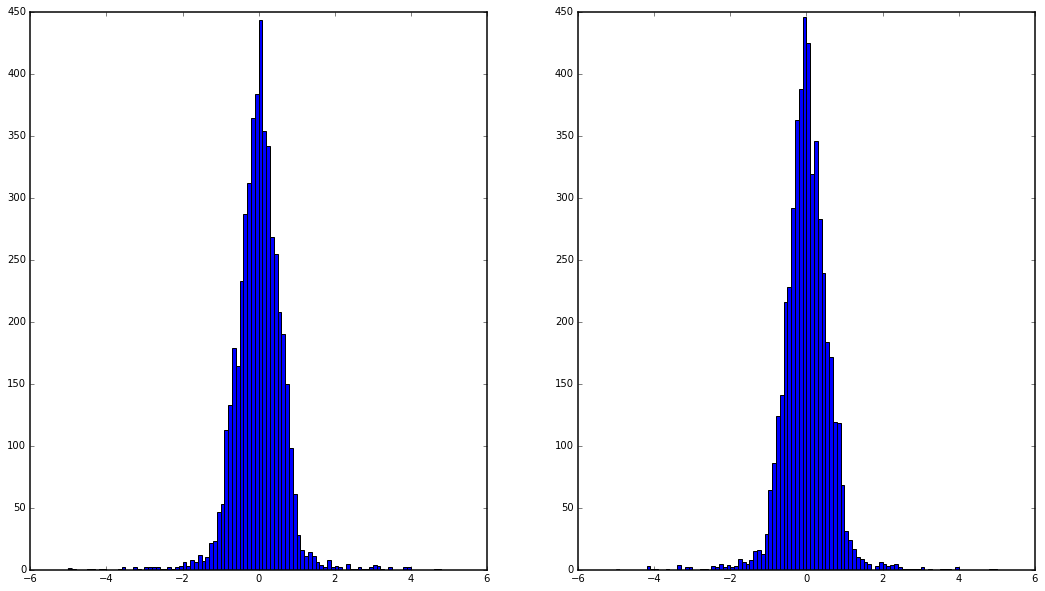

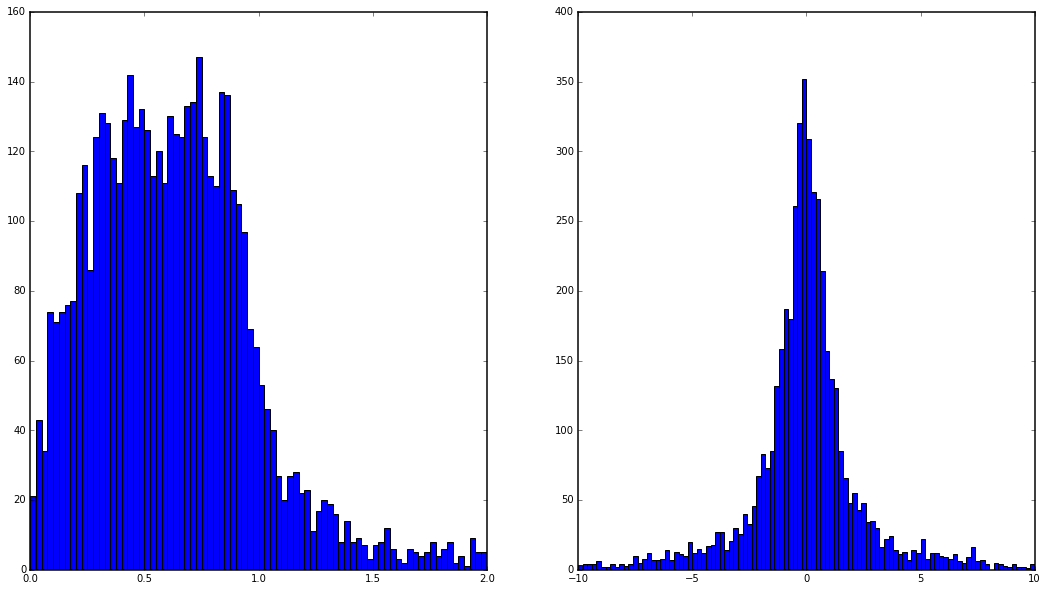

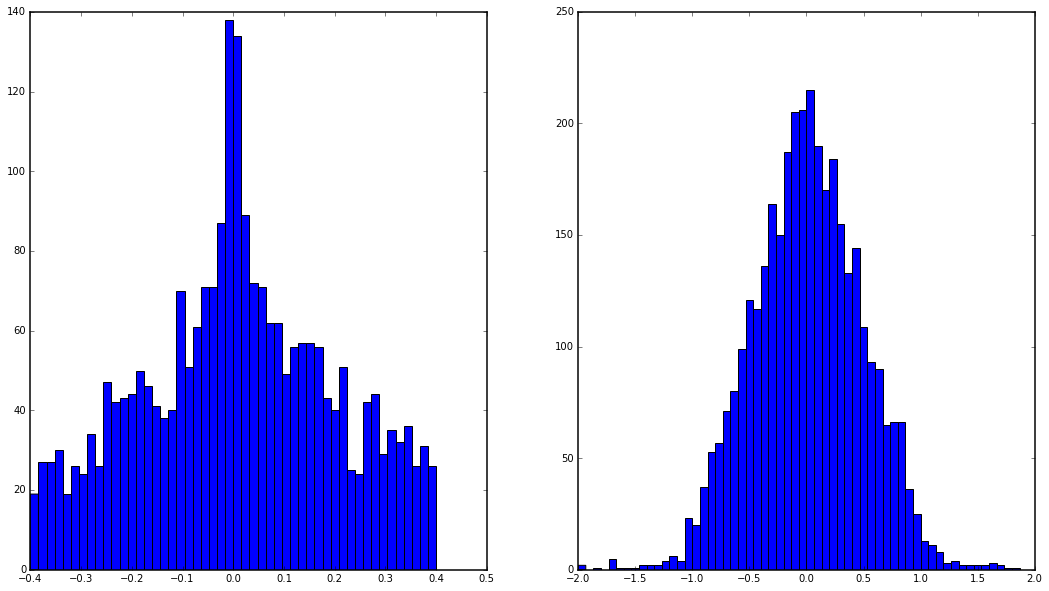

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 10))
ax0.hist(e1R, bins=100, range=[-5,5])
ax1.hist(e2R, bins=100, range=[-5,5])

mod = np.hypot(np.asarray(e1R), np.asarray(e2R))
tg = np.asarray(e2R)/np.asarray(e1R)

print np.mean(mod), np.median(mod)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 10))
ax0.hist(mod, bins=80, range=[0,2])
ax1.hist(tg, bins=100, range=[-10,10])

phi = np.arctan2(np.asarray(decSrc)-deClust, np.asarray(raSrc)-raClust)
gamT = -(np.asarray(e1R)*np.cos(2.0*phi) + np.asarray(e2R)*np.cos(2.0*phi))
gamC = -np.asarray(e1R)*np.sin(2.0*phi) + np.asarray(e2R)*np.cos(2.0*phi)

indx = np.where((gamT<0.2) & (gamT>-0.2))

print np.median(gamT[indx]), np.median(gamC)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 10))
ax0.hist(gamT[indx6], bins=50, range=[-0.4,0.4])
ax1.hist(gamC[indx6], bins=60, range=[-2,2])